# CS 109 Final Project 2019

## Spotify Automatic Playlist Recommender


**Harvard University**<br/>
**December 2019**<br/>
**Authors**: Maggie Basta, Alex Gibbons, Michael Wornow and Jared Yanis

<hr style="height:2pt">

**Table of Contents**
1. Part 1: EDA
    - 1.1: MDP EDA
        - 1.1.1: Exploring MDP dataset structure and format
        - 1.1.2: Exploring MDP Features
    - 1.2: Spotify API EDA
2. Part 2: Supervised Exploratory Models
    - 2.1 Data Engineering and Feature Extraction
    - 2.2 Logistic Regression
    - 2.3 Tree Models
    - 2.4 Evaluation of Models on Clicks
3. Part 3: Unsupervised Exploratory Models: K-means
    - 3.1 Building the model
    - 3.2 Choosing a K value
    - 3.3 Evaluation for chosen K
    - 3.4 PCA Evaluation
4. Part 4: Final two stage model
    - 4.1: Stage 1
    - 4.2 Stage 2
    
    
    





**WARNING - DEPENDENCIES**: 

While this notebook displays summarizes the work and findings of our project, it is very much dependent on several datasets, saved engineered features (via python's pickle library), and python scripts with helper functions. The following is a list of requiered datasets, pickle files and scripts needed to run the notebook through. Please also note that several of these files have global variables that need to be compiled for you directory structure (e.g. strings for paths to data, etc).

The following is a list of the dependencies and their descriptions:

- Datasets and pickle files
    1. The million song dataset: the original "MDP" dataset from the CS109a staff
    2. spotify_api_database.pickle: a list of all tracks and their spotify API features
    3. spotify_dictionary.pickle: the "spotify_api_database.pickle" in dictionary format
    4. mdp_wrmf_sparse_matrix_800.pickle: the precomputed sparse matrix representation of playlists and songs
    5. wrmf_factors.pickle: the saved factorization of "mdp_wrmf_sparse_matrix_800"
    6. wrmf_models_results.pickle: results from tests from wrmf on test playlists (for visuals)
    7. stage_2_val.pickle: saved output from test datasets after stage 1 to input to stage 2
    8. stage_2_train.pickle: saved output from training datasets after stage 1 to input to stage 2


- Scripts
    1. wrmf.py: computes the sparse matrix of playlists and songs and tunes factorization hyperparameters
    2. wrmf_helpers.py: helpers to use the matrix and its factorization from wrmf to predict songs
    3. settings.py: global settings for path variables (customized to your system's file structure)
    4. spotify_api_database.py: script to extract spotify audio features and accecss "Track" objects
    5. feature_extraction.py: script to extract features for stage 2 of the final model
    6. evaluation.py: script to evaluate clicks of the final model
    
These dependencies can be downloaded via these two places: 
- Google drive for large data and pickle files: https://drive.google.com/drive/folders/1a1BXy53hO8CVrfovNv2lpNLp632REMV_
- GitHub for scripts and smaller data and pickle files: https://github.com/maggiebasta/playlist-generation

In [1]:
"""
Use CS 109 Header style for organization
"""
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
"""
WARNING: due to the large data files loaded in the modules during imports, this cell takes a while to run
"""
import json
import os
import sys
import pickle
import itertools
import time
import datetime 
from os.path import isfile, join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import scipy.sparse as sparse

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 
import xgboost as xgb

sys.path.append('Models')
from evaluation import get_model_clickscore
import wrmf, wrmf_helpers
from settings import PATH_TO_SPARSE_MATRIX

import warnings
warnings.filterwarnings("ignore")

# Part 1: EDA

We started by doing a very high level EDA of our initial MDP data. While we also explored other options for data like the million song data set, we focused on the million playlist dataset. Below is our initial exploration.

## 1.1 MDP EDA

### 1.1.1 Exploring MDP dataset structure and format

The MDP was formatted into 1000 indentically structured csvs. We start by looking at an individual slice to get a sense of the basics like features, size and datatypes.

In [3]:
df_songs0 = pd.read_csv('data/Songs/songs0.csv', index_col=0)
df_songs0.shape

(67503, 8)

In [4]:
df_songs0.head()

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name
pid,,,,,,,,
0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook
0,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone
0,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit)
0,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified
0,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot


In [5]:
df_songs0.dtypes

pos             int64
artist_name    object
track_uri      object
artist_uri     object
track_name     object
album_uri      object
duration_ms     int64
album_name     object
dtype: object

In [6]:
df_songs0.describe()

,pos,duration_ms
count,67503.000000,6.750300e+04
mean,55.638223,2.331839e+05
std,49.051327,6.455234e+04
min,0.000000,0.000000e+00
25%,17.000000,1.984130e+05
50%,41.000000,2.248660e+05
75%,82.000000,2.580400e+05
max,244.000000,2.424189e+06


### 1.1.2 Exploring MDP Features

To get more familiar with the data, we also inspected the contents further by looking at the values of certain features. For example, we were able to inspect at the commonly seen artists for several sub-datasets of the data. 

In [7]:
def plot_popular_artists(df, ax):
    artist_list = df.artist_name
    Artists = {artist:0 for artist in artist_list.unique()}

    for a in artist_list:
        Artists[a] += 1

    popular_artists = sorted(list(Artists.items()), key=lambda x: x[1], reverse=True)[:20]
    labels, counts = zip(*popular_artists)

    ax.barh(list(range(len(counts))), counts, tick_label=labels)

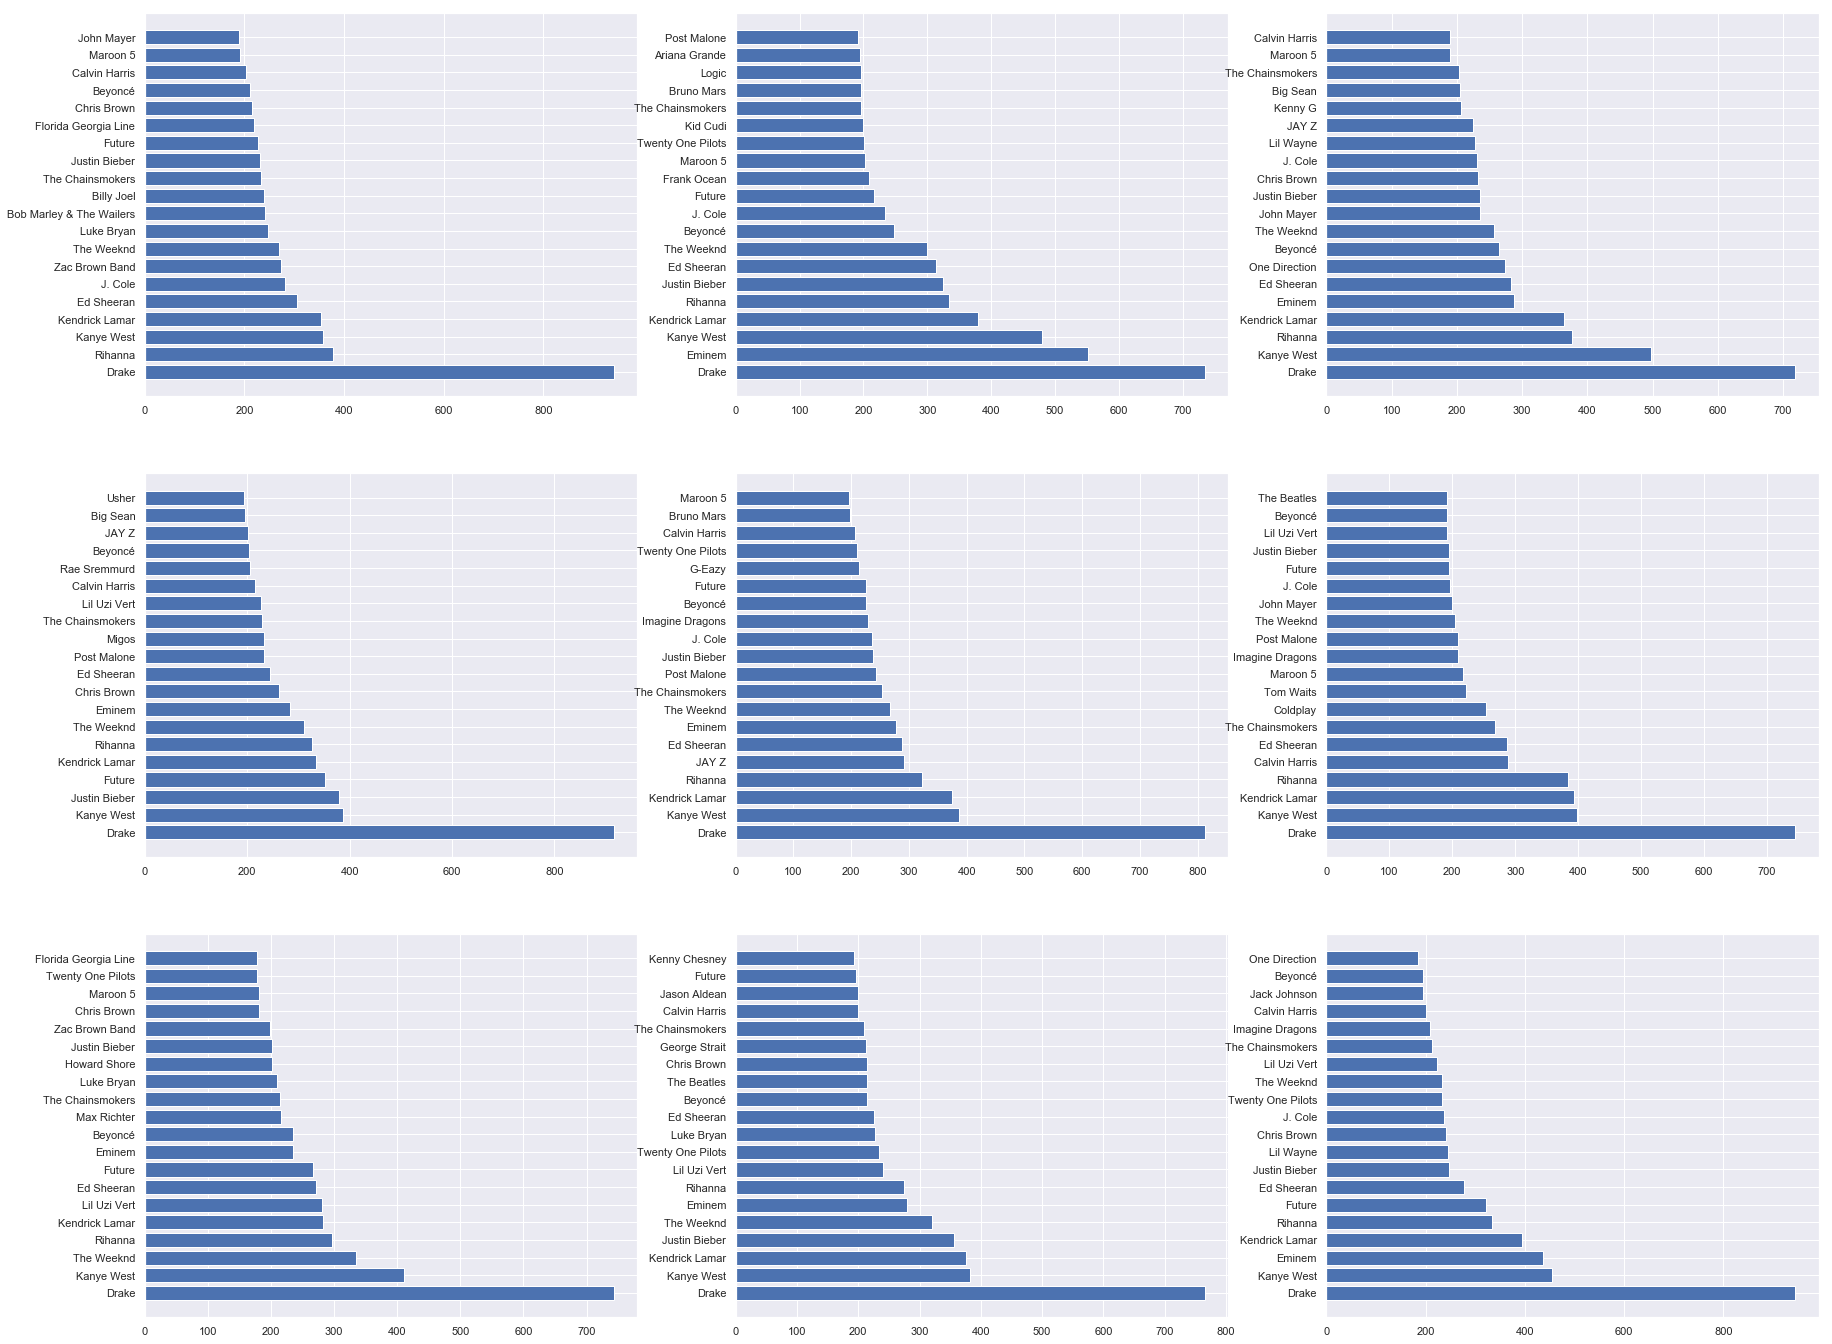

In [8]:
samples = np.arange(99, 999, 100)
dframes = [pd.read_csv(f"data/Songs/songs{i}.csv", index_col=0) for i in samples]

df_songs0.shape
fig, axs = plt.subplots(3, 3, figsize=(30, 24))
for ax, df in zip(axs.reshape(-1), dframes):  
    plot_popular_artists(df, ax)

## 1.2 Spotify API EDA 

In addition to the MDP data, we also found that nearly all of the songs in MDP dataset had additional features available by querying the spotify API. To streamline this process, we created a python script (see spotify_api_database.py) to extract all features for these songs, store them as a customized python "Track" object, and save them in a pickle file for future use. 

**Extraction from pickled "spotify_api_database" file:**

Given the size of the datak, we have stored all of the features for our track in a pickle file. This allows us to easily extract the data and transform it into a dataframe for exploration and further modeling without having to call the API again.

In [11]:
# Getting all of the playlist data
playlists = pd.DataFrame()

for i in ['0-999', '1000-1999']:
    data = json.load(open(f'data/mpd.slice.{i}.json'))
    playlists_concat = pd.DataFrame(data["playlists"])
    
    playlists = pd.concat([playlists, playlists_concat], ignore_index = True)

# Getting all of the song information
from spotify_api_database import Track 

########################
########################
# NOTE: First, you need to go to: https://drive.google.com/open?id=14h1Hpdg1aLosORY6qRENhjTSqIt680SZ
# and download the file named 'spotify_api_database.pickle'
# Second, place this file in the "Data/" directory of this Github repo
########################
########################
INPUT_FILE = 'data/spotify_api_database.pickle'

########################
########################
# Read in .pickle file
########################
########################

with open(INPUT_FILE, 'rb') as fd:
    start_time = time.time()
    print("Reading Spotify API Database .pickle file...")
    tracks = pickle.load(fd)
    print("Finished reading file (" + str(time.time() - start_time) +"s)...")

########################
########################
# The "tracks" variable is now an array of ~2M Track() objects
# The definition of the Track() class is in "spotify_api_database" -- note how we need to import this on line 7
########################
########################
# Print out first 100 tracks
for idx, t in enumerate(tracks):
    print(str(t) + ' | ' + t.get_audio_feats())
    # NOTE: Some tracks did not have audio feature data on Spotify (~600)
    if idx > 100:
        break


Reading Spotify API Database .pickle file...
Finished reading file (383.2030928134918s)...
You Lay A Whole Lot Of Love On Me, by Shania Twain | Danceability: 0.61 | Energy: 0.458
Time Has Come, by Hugh Mundell | Danceability: 0.795 | Energy: 0.302
What The Hell Did I Say, by Dierks Bentley | Danceability: 0.574 | Energy: 0.821
Higher Ground, by Wrekonize | Danceability: 0.467 | Energy: 0.842
Canta (En Vivo) [feat. Jorge Luis Chacín], by Guaco, Jorge Luis Chacin | Danceability: 0.81 | Energy: 0.622
Sunlight, by Imaginary Future | Danceability: 0.675 | Energy: 0.604
Avant, by Sonia Wieder-Atherton | Danceability: 0.183 | Energy: 0.23
Dorothy, by The Lion and Atilla | Danceability: 0.591 | Energy: 0.381
Love Is... (feat. Jan, Sy Smith), by The Brand New Heavies, Jan, Sy Smith | Danceability: 0.777 | Energy: 0.605
Hail Mary (feat. The Outlawz), by 2Pac, Outlawz | Danceability: 0.481 | Energy: 0.844
Za unuka mog, by Fazlija | Danceability: 0.566 | Energy: 0.886
Ballistic, by Skorge | Dancea

In [12]:
### LOAD TRACK DATA TO RECTANGULAR MATRIX

my_tracks = []
for i in range(len(tracks)):
    my_dict = dict()
    my_dict["id"] = tracks[i].id
    my_dict["name"] = tracks[i].name
    my_dict["artists"] = tracks[i].artists[0][1]
    my_dict["album"] = tracks[i].album

    try: 
        my_dict["danceability"] = tracks[i].danceability
    except: 
        my_dict["danceability"] = None

    try:
        my_dict["energy"] = tracks[i].energy
    except:
        my_dict["energy"] = None

    try:
        my_dict["key"] = tracks[i].key
    except:
        my_dict["key"] = None

    try:
        my_dict["loudness"] = tracks[i].loudness
    except:
        my_dict["loudness"] = None

    try:
        my_dict["mode"] = tracks[i].mode
    except:
        my_dict["mode"] = None

    try:
        my_dict["speechiness"] = tracks[i].speechiness
    except: 
        my_dict["speechiness"] = None

    try:
        my_dict["acousticness"] = tracks[i].acousticness
    except:
        my_dict["acousticness"] = None

    try:
        my_dict["instrumentalness"] = tracks[i].instrumentalness
    except: 
        my_dict["instrumentalness"] = None

    try:
        my_dict["liveness"] = tracks[i].liveness
    except:
        my_dict["liveness"] = None

    try:
        my_dict["valence"] = tracks[i].valence
    except:
        my_dict["valence"] = None

    try:
        my_dict["tempo"] = tracks[i].tempo
    except:
        my_dict["tempo"] = None

    try:
        my_dict["duration_ms"] = tracks[i].duration_ms
    except:
        my_dict["duration_ms"] = None

    try:
        my_dict["time_signature"] = tracks[i].time_signature
    except:
        my_dict["time_signature"] = None

    my_tracks.append(my_dict)

### DROP NON-NUMERIC DATA
my_tracks2 = my_tracks.dropna()
 
### DROP ROWS CONTAINING NANS

my_tracks3 = my_tracks2.drop(["artists", "id", "name", "album"], axis = 1)

In [13]:
my_tracks = pd.DataFrame(my_tracks)
my_tracks.head()

,id,name,artists,album,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,006gwoshpgwOisFogU85xF,You Lay A Whole Lot Of Love On Me,Shania Twain,,0.610,0.458,11.0,-10.819,1.0,0.0274,0.501000,0.000000,0.1040,0.440,108.374,168933.0,4.0
1,00FtrGVrRAIjjMfqAWktvt,Time Has Come,Hugh Mundell,,0.795,0.302,9.0,-17.141,0.0,0.1440,0.009530,0.040600,0.1630,0.738,128.561,224760.0,4.0
2,00AxNl4D4jHL2AEf1W55j5,What The Hell Did I Say,Dierks Bentley,,0.574,0.821,2.0,-4.742,0.0,0.0268,0.000446,0.000002,0.1910,0.299,108.000,207333.0,4.0
3,008bSgDpnWOAdcxcHxJxQr,Higher Ground,Wrekonize,,0.467,0.842,2.0,-5.183,0.0,0.4290,0.230000,0.000000,0.0897,0.408,94.499,238032.0,3.0
4,00N0HLqc3ebGR2DKcH8cU4,Canta (En Vivo) [feat. Jorge Luis Chacín],Guaco,,0.810,0.622,1.0,-12.715,1.0,0.0671,0.419000,0.000070,0.1530,0.961,103.915,233190.0,4.0


# Part 2: Supervised Exploratory Models

## 2.1 Data Engineering and Feature Extraction 

### Modeling the data

Now that we have data from the spotify API, we still need to combine it with our playlist data from the MDP. This process is made possible by the fact that both datasets use the same track_id identifiers. 

In [15]:
# Getting a subset of the playlists
playlist_subset = playlists[:1000]
playlist_subset.shape

# Getting the subset of the songs in the playlists
id_dict = {}
    
# Get a dictionary of all the song id's used in a playlist
def populate_track_subset(row, ids):
    tracks = row['tracks']
    
    for track in tracks:
        track_id = track['track_uri'][14:]
        if track_id not in ids:
            ids[track_id] = True    
    
playlist_subset.apply(lambda row: populate_track_subset(row, id_dict), axis=1);

track_subset = my_tracks[my_tracks["id"].isin(id_dict)]
track_subset = track_subset.set_index('id')
track_subset.drop(['artists', 'name', 'album'], inplace=True, axis=1)
track_subset.shape

(34441, 13)

In [16]:
track_subset.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
id,,,,,,,,,,,,,
00CmjeeHvAVKvx3tcIiZTy,0.679,0.412,2.0,-16.962,1.0,0.0305,0.416000,0.000000,0.128,0.963,105.903,166733.0,4.0
00DlEKhhlQNtjnJk7xqB9O,0.500,0.890,10.0,-4.094,0.0,0.0420,0.000404,0.000000,0.085,0.360,138.743,282464.0,4.0
006yrnQMCZpiUgkR612gC8,0.751,0.829,10.0,-2.007,0.0,0.1090,0.052900,0.000076,0.498,0.275,140.118,123411.0,4.0
00JvkzL9d727hk4Mzy1eyg,0.560,0.794,11.0,-6.395,0.0,0.0527,0.866000,0.000009,0.155,0.464,124.996,206293.0,4.0
00NUqFMIpCsrYPbM9YpVHQ,0.504,0.856,11.0,-5.024,0.0,0.2860,0.011400,0.000000,0.256,0.335,101.866,198280.0,5.0


###  Creating a classification task

While we now have the spotify API data for our playlists, this doesn't yet help us identify what is indicative of a song being a good fit for a playlist or not. However, we can relate the songs to their playlists by computing the relationship between an individual song's features and the average of the features of all the songs the playlists. We can also compute this relationship for songs *not* in the playlist. This gives us a binary classification task where certain relationships between song features and average playlist features are indicative of a match and other relationships are indicative of not a match. 

**Creating the average playlist statistics**

In [ ]:
# Getting an index row
playlist_subset.reset_index(inplace=True)

In [18]:
# Creating the new empty dataframe
ps = []

def populate_playlist_statistics(row, ps):
    # Get all the tracks, the list of ids, and the index
    tracks, ids, num_tracks = row['tracks'], [], row['num_tracks']
        
#     Iterate through the tracks
    for track in tracks:
        ids.append(track['track_uri'][14:])
                        
    playlist_track_subset = track_subset.loc[ids, :].sum()/num_tracks
    playlist_track_subset = playlist_track_subset.tolist() + [num_tracks]

    ps.append(playlist_track_subset)
    
# Applying the function
playlist_subset.apply(lambda row: populate_playlist_statistics(row, ps), axis=1);

In [19]:
playlist_statistics=pd.DataFrame(ps,columns=track_subset.columns.tolist() + ['num_tracks'])
playlist_statistics.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_tracks
0,0.659288,0.782173,5.038462,-4.881942,0.692308,0.107021,0.083440,0.000676,0.192127,0.642904,123.006885,221777.461538,4.000000,52
1,0.496459,0.691077,4.461538,-8.291667,0.538462,0.088449,0.163100,0.222270,0.178433,0.476667,122.669615,298844.128205,3.769231,39
2,0.671875,0.693203,5.000000,-4.874156,0.515625,0.096288,0.269230,0.000638,0.169028,0.565078,114.600672,219374.875000,4.000000,64
3,0.513714,0.621282,5.103175,-9.614937,0.714286,0.067186,0.273870,0.202042,0.188585,0.451623,125.032413,229575.055556,3.952381,126
4,0.576765,0.650535,3.352941,-7.634471,0.823529,0.041159,0.177148,0.081875,0.166524,0.490765,127.759882,255014.352941,3.941176,17


**Creating the song playlist dataset**

Adding the songs in the playlists

In [20]:
# Creating the new empty dataframe
ss = []

def populate_playlist_statistics(row, ss):
    # Get all the tracks, the list of ids, and the index
    tracks, index = row['tracks'], row['index']
        
    # Iterate through the tracks
    for track in tracks:
        track_id = track['track_uri'][14:]
        
        # Some have error and I dont know why
        try:
            # Get track and playlist info
            track_info = np.append(track_subset.loc[track_id, :].values, [0])            
            playlist_info = playlist_statistics.loc[index, :].values
            
            # Get the difference
            track_info = playlist_info - track_info
            track_info = track_info.tolist() + [1]
                        
            # Add to ss
            ss.append(track_info)
        except:
            print(track_id)

# Applying the function
playlist_subset.apply(lambda row: populate_playlist_statistics(row, ss), axis=1);

656TZlNdVe90zHvmebFt9U
5GiU7GOYjDH2yp7fMf9w9j


In [21]:
song_playlist_statistics=pd.DataFrame(ss, columns=playlist_statistics.columns.tolist() + ['in_playlist'])
song_playlist_statistics.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_tracks,in_playlist
0,-0.244712,-0.030827,1.038462,2.223058,0.692308,-0.013979,0.05234,-0.006294,0.145027,-0.167096,-2.454115,-5086.538462,0.0,52.0,1
1,-0.114712,-0.055827,0.038462,-0.967942,0.692308,-0.006979,0.05854,-0.024324,-0.049873,-0.281096,-20.033115,22977.461538,0.0,52.0,1
2,-0.004712,0.024173,3.038462,1.701058,0.692308,-0.102979,0.08106,0.000676,0.132327,-0.058096,23.747885,-14155.538462,0.0,52.0,1
3,-0.231712,0.068173,1.038462,1.173058,0.692308,-0.032979,-0.11856,0.000442,0.140027,-0.175096,22.034885,-45489.538462,0.0,52.0,1
4,-0.193712,0.176173,5.038462,-0.285942,-0.307692,0.035721,0.02734,0.000676,-0.120873,-0.011096,28.247885,-5822.538462,0.0,52.0,1


**Randomly Choosing 67501 Songs To Use As "Not In Playlist Songs"**

In [22]:
# Initializitng a matrix with all song playlist relationships
# Use like "tpm_d[playlist] [tpm_d[track it]]"
tpm = [[0 for i in range(len(track_subset.index))] for j in range(len(playlist_statistics.index))]

# Dictionaries to go id --> column_number and column_number --> id
tpm_d = {}
tpm_d2 = {}
for i, track_id in zip([i for i in range(len(track_subset.index))], track_subset.index):
    tpm_d[track_id] = i
    tpm_d2[i] = track_id

In [23]:
def populate_track_playlist_matrix(row, tpm):
    # Get all the tracks, the list of ids, and the index
    tracks, index = row['tracks'], row['index']
        
    # Iterate through the tracks
    for track in tracks:
        # Updating the shit
        track_id = track['track_uri'][14:]
        
        # Some have error and I dont know why
        try:
            tpm[index][tpm_d[track_id]] = 1
        except:
            print(track_id)

# Applying the function
playlist_subset.apply(lambda row: populate_track_playlist_matrix(row, tpm), axis=1);

656TZlNdVe90zHvmebFt9U
5GiU7GOYjDH2yp7fMf9w9j


In [24]:
# Making the matrix
track_playlist_matrix = pd.DataFrame(tpm)
track_playlist_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,34431,34432,34433,34434,34435,34436,34437,34438,34439,34440
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
track_playlist_matrix.shape

(1000, 34441)

In [ ]:
# Getting all of the index combos
tpm_ind = track_playlist_matrix.stack()
tpm_ind = tpm_ind[tpm_ind == 0]
tpm_ind = tpm_ind.index.tolist()

In [27]:
import random
# Sort randomly
random.shuffle(tpm_ind)

In [28]:
# # Saving out the file
# with open('tpm_indicies.pkl', 'wb') as f:
#     pickle.dump(tpm_ind, f)

**Adding "Not in Playlist Songs" to the song_playlist_statistic df**

In [29]:
ss2 = []

for i in range(song_playlist_statistics.shape[0]):
    # Getting the playlist, song combo
    row, col = tpm_ind[i]
    index, track_id = row, tpm_d2[col]
    
    # Get track and playlist info
    track_info = np.append(track_subset.loc[track_id, :].values, [0])            
    playlist_info = playlist_statistics.loc[index, :].values

    # Get the difference
    track_info = playlist_info - track_info
    track_info = track_info.tolist() + [0]

    # Add to ss
    ss2.append(track_info)

In [30]:
full_song_playlist_statistics=pd.DataFrame(ss + ss2, columns=playlist_statistics.columns.tolist() + ['in_playlist'])
full_song_playlist_statistics.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_tracks,in_playlist
0,-0.244712,-0.030827,1.038462,2.223058,0.692308,-0.013979,0.05234,-0.006294,0.145027,-0.167096,-2.454115,-5086.538462,0.0,52.0,1
1,-0.114712,-0.055827,0.038462,-0.967942,0.692308,-0.006979,0.05854,-0.024324,-0.049873,-0.281096,-20.033115,22977.461538,0.0,52.0,1
2,-0.004712,0.024173,3.038462,1.701058,0.692308,-0.102979,0.08106,0.000676,0.132327,-0.058096,23.747885,-14155.538462,0.0,52.0,1
3,-0.231712,0.068173,1.038462,1.173058,0.692308,-0.032979,-0.11856,0.000442,0.140027,-0.175096,22.034885,-45489.538462,0.0,52.0,1
4,-0.193712,0.176173,5.038462,-0.285942,-0.307692,0.035721,0.02734,0.000676,-0.120873,-0.011096,28.247885,-5822.538462,0.0,52.0,1


In [31]:
full_song_playlist_statistics.shape

(135002, 15)

In [32]:
test=pd.DataFrame(ss2, columns=playlist_statistics.columns.tolist() + ['in_playlist'])

In [33]:
test.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_tracks,in_playlist
count,67501.000000,67501.000000,67501.000000,67501.000000,67501.000000,67501.000000,67501.000000,67501.000000,67501.000000,67501.000000,67501.000000,6.750100e+04,67501.000000,67501.000000,67501.0
mean,0.017516,-0.006167,-0.059525,0.152771,-0.000776,0.000914,-0.009077,-0.020688,-0.009776,0.005678,-0.564608,-1.205090e+03,0.009343,67.094932,0.0
std,0.188902,0.262072,3.648447,4.677155,0.493854,0.117626,0.350181,0.249324,0.175960,0.273331,30.050827,8.037559e+04,0.389360,54.842111,0.0
min,-0.700533,-0.945638,-10.428571,-29.290500,-0.900000,-0.922263,-0.983338,-0.991000,-0.879713,-0.861300,-112.976083,-2.202140e+06,-1.916201,5.000000,0.0
25%,-0.114078,-0.192000,-3.114286,-2.503077,-0.400000,-0.022258,-0.209178,0.000058,-0.066588,-0.197235,-19.843714,-3.405165e+04,-0.090909,25.000000,0.0
50%,0.012897,-0.026286,-0.149485,-0.328300,-0.220588,0.016629,0.065160,0.006516,0.047116,0.013095,0.274026,6.300194e+03,-0.027907,50.000000,0.0
75%,0.143444,0.165750,3.350427,2.326565,0.553846,0.055759,0.196553,0.039693,0.093249,0.210444,22.542247,4.185474e+04,0.000000,92.000000,0.0
max,0.736771,0.891850,9.000000,51.732018,1.000000,0.762487,0.989859,0.914923,0.689587,0.860261,135.735209,3.476014e+05,4.058824,245.000000,0.0


In [34]:
test = test.describe()
test.to_csv(r'Desc2.csv')

## 2.2 Logistic Regression

Now that we have a dataset we can model on, we start with a logistic regression. While a seemingly trivial model for the task, the interpretability allows us to gain some useful insights and inspiration for the direction of future work. 

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [37]:
fsps = full_song_playlist_statistics.drop(columns=['num_tracks'])

X_train, X_test, y_train, y_test = train_test_split(fsps.loc[:, fsps.columns != 'in_playlist'], 
                                                             fsps.in_playlist, test_size=0.2, 
                                                             random_state = 109, 
                                                             stratify = fsps.in_playlist)
print('Shape before splitting: ' + str(fsps.shape))
print('Shapes after splitting: ' + str((X_train.shape, X_test.shape, y_train.shape, y_test.shape)))

Shape before splitting: (135002, 14)
Shapes after splitting: ((108001, 13), (27001, 13), (108001,), (27001,))


In [38]:
# Making sure the data is 
Log_cv = LogisticRegressionCV(max_iter=10000, cv = 4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [39]:
# Printing the results
print(f"Accuracy on the training set: {accuracy_score(Log_cv.predict(X_train), y_train)}")
print(f"Accuracy on the testing set: {accuracy_score(Log_cv.predict(X_test), y_test)}")

Accuracy on the training set: 0.5377450208794363
Accuracy on the testing set: 0.5324617606755305


**Interpreting Results**

Despite the poor performance of the model (as expected), we still look at the coefficients and their relationship to predictions to see if there are any interesting findings or suggestions for further exploration. 

In [40]:
# Getting all the coefficient values
Log_cv_coef = Log_cv.coef_.tolist()[0]

for predictor, coef in zip(fsps.columns.tolist(), Log_cv_coef):
    print(f"Predictor: {predictor} {coef}")

Predictor: danceability -0.47669680521986574
Predictor: energy 0.6242792327227328
Predictor: key 0.0038661730513287976
Predictor: loudness -0.020730219161515986
Predictor: mode 0.003580416046076381
Predictor: speechiness 0.11364579115195306
Predictor: acousticness 0.17748524648646133
Predictor: instrumentalness 0.3941865191294186
Predictor: liveness 0.24837181243903128
Predictor: valence -0.0049234301084750565
Predictor: tempo 8.130743088949147e-05
Predictor: duration_ms 4.587963069369304e-08
Predictor: time_signature -0.02770160004169865


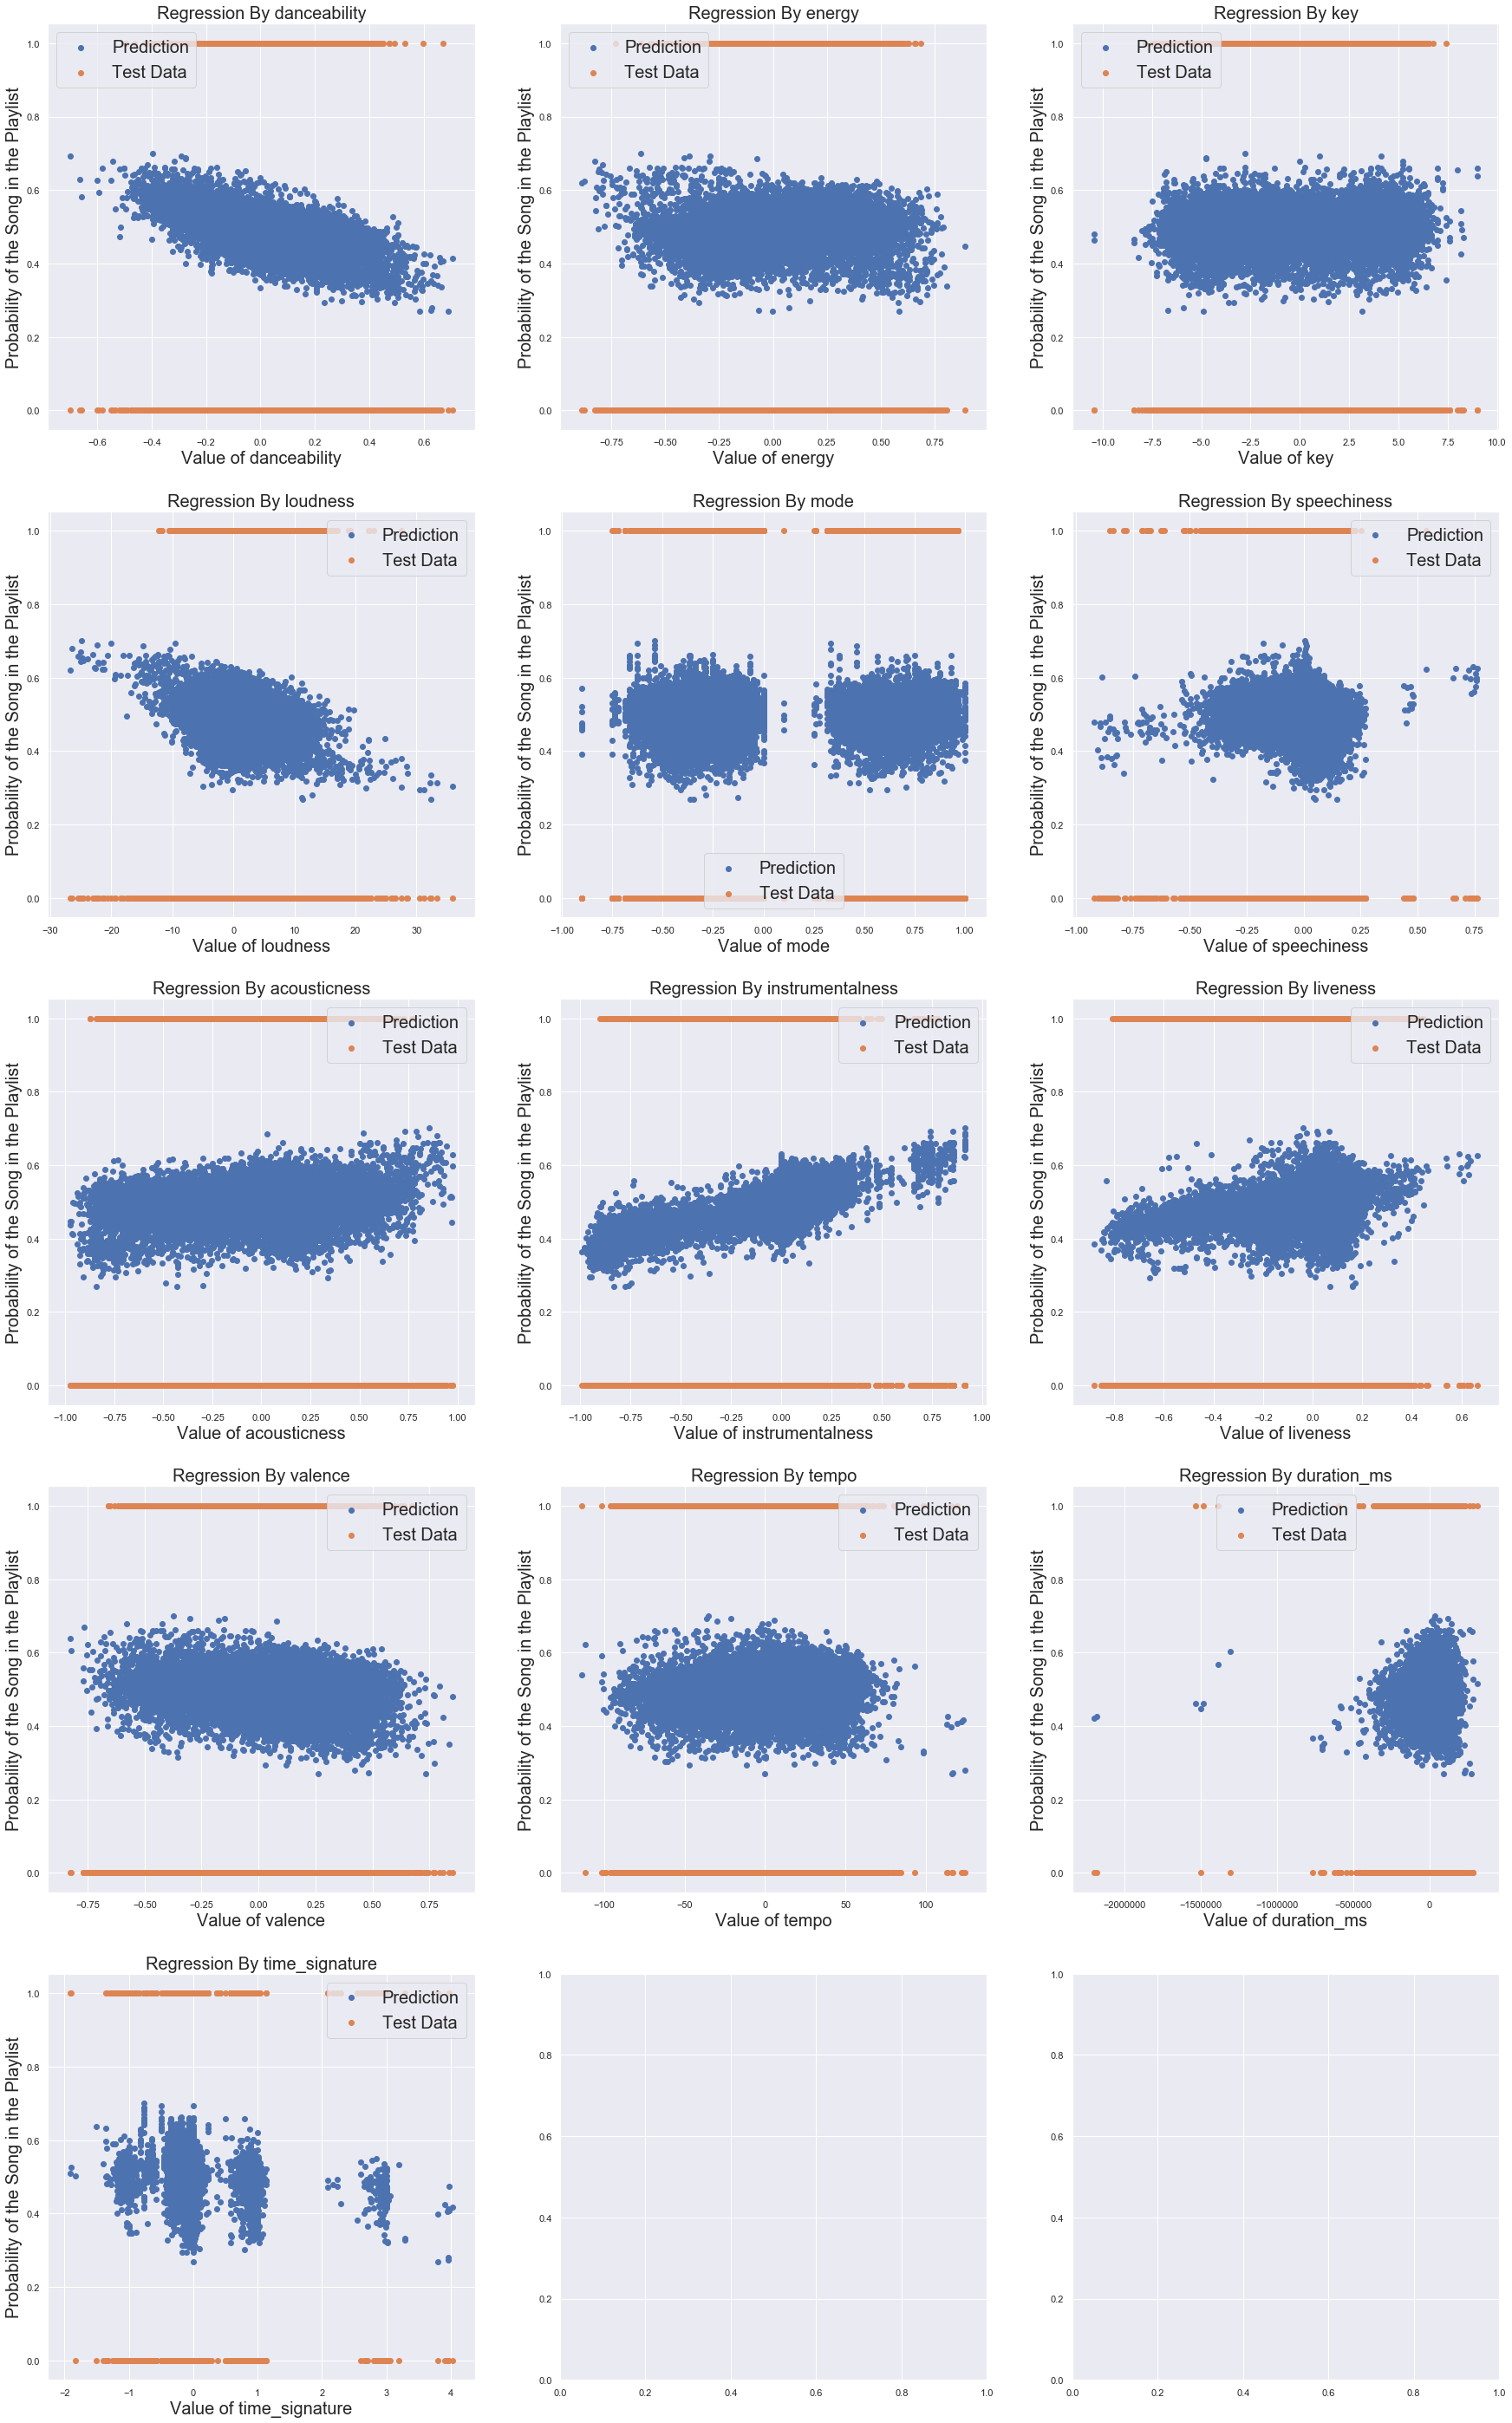

In [41]:
# Drawing the plots
fig, ax = plt.subplots(5,3, figsize = (30, 50))

# make the prediction at each x value
prediction = Log_cv.predict_proba(X_test)[:, 1].tolist()

size=20

for i in range(len(X_test.columns.tolist())):
    feature = X_test.columns.tolist()[i]
    # plot the prediction line, and the test data
    ax[i//3][i%3].scatter(X_test.loc[:, feature].tolist(), prediction, label="Prediction")
    ax[i//3][i%3].scatter(X_test.loc[:, feature].tolist(), y_test.tolist(), label="Test Data")

    # label your plots
    ax[i//3][i%3].set_ylabel("Probability of the Song in the Playlist", fontsize=size)
    ax[i//3][i%3].set_xlabel(f"Value of {feature}", fontsize=size)
    ax[i//3][i%3].set_title(f"Regression By {feature}", fontsize=size)
    ax[i//3][i%3].legend(fontsize=size)

## 2.3 Tree Models

The poor performance of the logistic regression model is a clear motivation for exploration of more powerful models. Therefore, our next step was to look into tree based models. We explored 3 different types of models: a basic cross validated decision tree, a bagged decision tree, and a random forest models. 

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

from sklearn import tree

**Basic Tree Model**

In [43]:
### cs109Test(test_1.1a) ###

depths = list(range(1, 45))

def calc_meanstd(X_train, y_train, depths):
    # Initialize the outputs
    cvmeans, cvstds, train_scores, test_scores = [], [], [], []
    
    # Look through all max depths
    for depth in depths:
        # Making the model and the scores
        dt = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
        cv_score = cross_val_score(dt, X_train, y_train, cv=5)
        
        # Getting the relevant statistics
        cvmeans.append(np.mean(cv_score))
        cvstds.append(np.std(cv_score))
        train_scores.append(accuracy_score(y_train, dt.predict(X_train)))
        test_scores.append(accuracy_score(y_test, dt.predict(X_test)))
        
    # Turn to np arrays
    cvmeans, cvstds = np.asarray(cvmeans), np.asarray(cvstds)
    train_scores, test_scores = np.asarray(train_scores), np.asarray(test_scores)
        
    # end of your code here
    return cvmeans, cvstds, train_scores, test_scores

In [44]:
cvmeans, cvstds, train_scores, test_scores = calc_meanstd(X_train, y_train, depths)

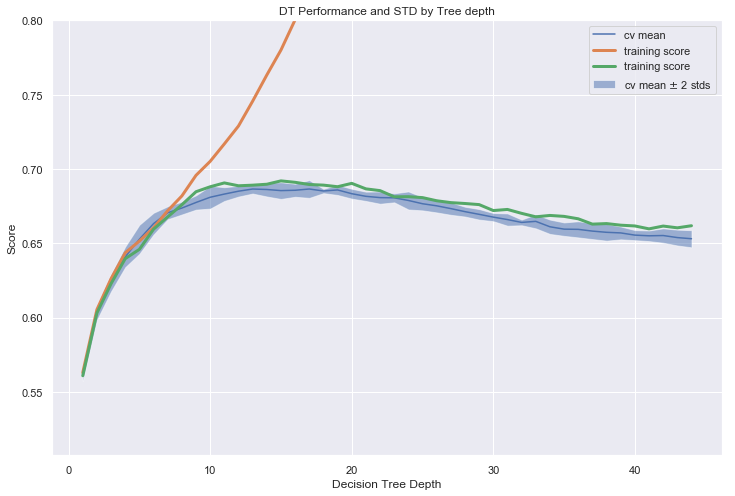

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# mean -2 STDs
y1 = cvmeans - cvstds*2
# mean +2 STDs
y2 = cvmeans + cvstds*2

ax.fill_between(depths, y1,y2, alpha=.5, label='cv mean $\pm$ 2 stds')
ax.plot(depths, cvmeans, label='cv mean')
ax.plot(depths, train_scores, label='training score', linewidth=3)
ax.plot(depths, test_scores, label='training score', linewidth=3)
ax.legend()
ax.set_xlabel("Decision Tree Depth")
ax.set_ylabel("Score")
ax.set_title("DT Performance and STD by Tree depth")
ax.set_ylim([min(y1)-.05, .8])
plt.show()

In [47]:
best_depth = np.where(cvmeans == np.amax(cvmeans))[0][0] + 1
Decision_tree = DecisionTreeClassifier(max_depth=best_depth).fit(X_train, y_train)

print(f'Best Depth: {best_depth}')
print(f'Best Cross Validation: {np.amax(cvmeans)}')

Best Depth: 17
Best Cross Validation: 0.6865121685038588


**Bagging Tree**

In [50]:
tree_depth = 60

tree60 = DecisionTreeClassifier(max_depth = tree_depth, random_state=0).fit(X_train, y_train)
tree60_train_accuracy = accuracy_score(tree60.predict(X_train), y_train)
tree60_test_accuracy = accuracy_score(tree60.predict(X_test), y_test)

print(f"Tree depth {tree_depth} training accuracy: {round(tree60_train_accuracy*100, 2)}%")
print(f"Tree depth {tree_depth} test accuracy: {round(tree60_test_accuracy*100, 2)}%")

Tree depth 60 training accuracy: 100.0%
Tree depth 60 test accuracy: 66.1%


In [51]:
def bagger(n_trees: int, tree_depth: int) -> (pd.DataFrame, pd.DataFrame, list):
  
    print('test1')

    train_pred, test_pred, bagging_models = [], [], []
    
    # Create initial tree
    X_train_boost = X_train.copy()
    X_train_boost['class'] = y_train

    # Repeat the process n_trees times
    for i in range(n_trees):
        print(f'{i} start')
        # Create the bootstrapped data
        boot_data = resample(X_train_boost, replace=True)
        X_boot = boot_data.drop('class', axis=1)
        y_boot = boot_data['class']
                
        # Create the model itself
        dt = DecisionTreeClassifier(max_depth=tree_depth).fit(X_boot, y_boot)
        train_pred.append(dt.predict(X_train))
        test_pred.append(dt.predict(X_test))

        # Adding the model
        bagging_models.append(dt)
        
    bagging_train = pd.DataFrame(
        data=np.array(train_pred).T,
        index=X_train.index 
    )
    
    bagging_test = pd.DataFrame(
        data=np.array(test_pred).T,
        index=X_test.index 
    )
    
    return bagging_train, bagging_test, bagging_models

In [52]:
bagging_train_df, bagging_test_df, bagging_models = bagger(55, tree_depth)

test1
0 start
1 start
2 start
3 start
4 start
5 start
6 start
7 start
8 start
9 start
10 start
11 start
12 start
13 start
14 start
15 start
16 start
17 start
18 start
19 start
20 start
21 start
22 start
23 start
24 start
25 start
26 start
27 start
28 start
29 start
30 start
31 start
32 start
33 start
34 start
35 start
36 start
37 start
38 start
39 start
40 start
41 start
42 start
43 start
44 start
45 start
46 start
47 start
48 start
49 start
50 start
51 start
52 start
53 start
54 start


In [53]:
combined_train_preds = [sum(row[1].values) >= 27 for row in bagging_train_df.iterrows()]
combined_test_preds = [sum(row[1].values) >= 27 for row in bagging_test_df.iterrows()]

bagging_accuracy_train = accuracy_score(combined_train_preds, y_train)
bagging_accuracy_test = accuracy_score(combined_test_preds, y_test)

print(f"Bagging train accuracy: {round(bagging_accuracy_train*100, 2)}%")
print(f"Bagging test accuracy: {round(bagging_accuracy_test*100, 2)}%")

Bagging train accuracy: 99.99%
Bagging test accuracy: 74.62%


In [54]:
trained_scores = []
for i in range(0, 55):
    bagging_train_subset = bagging_train_df.iloc[:, :i+1]
    
    print(i)
    
    val = max(1, i//2)
    combined_train_preds = [sum(row[1].values) >= val for row in bagging_train_subset.iterrows()]
    bagging_accuracy_train = accuracy_score(combined_train_preds, y_train)
    
    trained_scores.append(bagging_accuracy_train)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


In [56]:
tested_scores = []
for i in range(0, 55):
    bagging_test_subset = bagging_test_df.iloc[:, :i+1]
    
    print(i)
    
    val = max(1, i//2)
    combined_test_preds = [sum(row[1].values) >= val for row in bagging_test_subset.iterrows()]
    bagging_accuracy_test = accuracy_score(combined_test_preds, y_test)
    
    tested_scores.append(bagging_accuracy_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


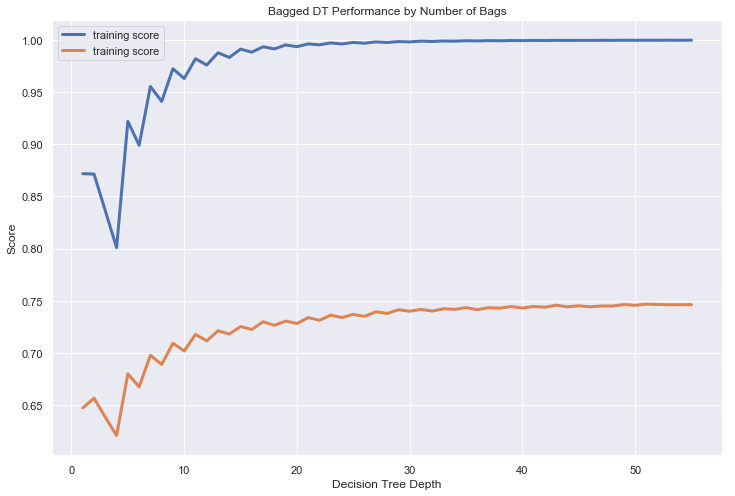

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

depths = list(range(1, 56))

ax.plot(depths, trained_scores, label='training score', linewidth=3)
ax.plot(depths, tested_scores, label='training score', linewidth=3)
ax.legend()
ax.set_xlabel("Decision Tree Depth")
ax.set_ylabel("Score")
ax.set_title("Bagged DT Performance by Number of Bags")
plt.show()

**Random Forrests**

In [58]:
rf_model = RandomForestClassifier(
    n_estimators=55,
    max_depth=38,
    max_features='sqrt', 
    random_state=0
)
rf_model.fit(X_train, y_train)

rf_train_preds = rf_model.predict(X_train)
rf_test_preds = rf_model.predict(X_test)

random_forest_train_score = accuracy_score(rf_train_preds, y_train)
random_forest_test_score = accuracy_score(rf_test_preds, y_test)

print(f"Random forest test accuracy: {round(random_forest_train_score*100, 2)}%")
print(f"Random forest test accuracy: {round(random_forest_test_score*100, 2)}%")

Random forest test accuracy: 99.45%
Random forest test accuracy: 75.27%


In [67]:
train_score, test_score, cross_vals = [], [], []

for i in range(1, 41):
    rf_model = RandomForestClassifier(
    n_estimators=55,
    max_depth=i,
    max_features='sqrt', 
    random_state=0)
    
    rf_model.fit(X_train, y_train)

    rf_train_preds = rf_model.predict(X_train)
    rf_test_preds = rf_model.predict(X_test)

    random_forest_train_score = accuracy_score(rf_train_preds, y_train)
    random_forest_test_score = accuracy_score(rf_test_preds, y_test)
    scores = cross_val_score(rf_model, X_train, y_train, cv=5)
    
    train_score.append(random_forest_train_score)
    test_score.append(random_forest_test_score)
    cross_vals.append(scores)
    
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [69]:
rf_cvmeans, rf_cvstds = [], []
for i in np.asarray(cross_vals):
    rf_cvmeans.append(np.mean(i))
    rf_cvstds.append(np.std(i))
    
rf_cvmeans = np.asarray(rf_cvmeans)
rf_cvstds = np.asarray(rf_cvstds)

In [70]:
len(train_score)

40

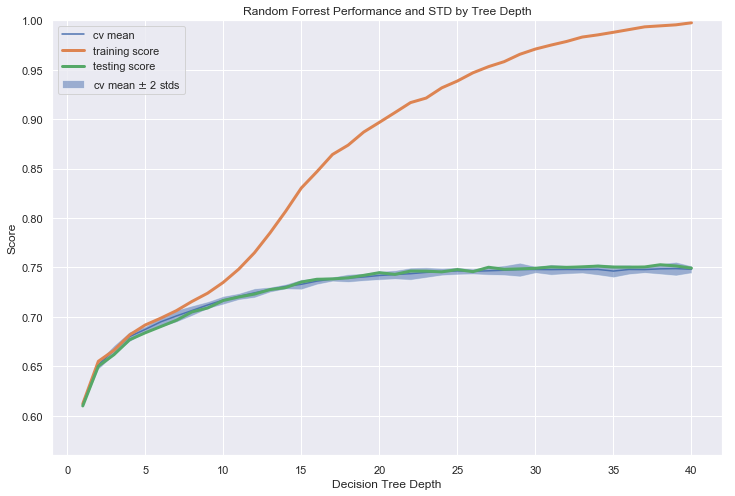

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

depths = range(1, 41)

# mean -2 STDs
y1 = rf_cvmeans - rf_cvstds*2
# mean +2 STDs
y2 = rf_cvmeans + rf_cvstds*2

ax.fill_between(depths, y1,y2, alpha=.5, label='cv mean $\pm$ 2 stds')
ax.plot(depths, rf_cvmeans, label='cv mean')
ax.plot(depths, train_score, label='training score', linewidth=3)
ax.plot(depths, test_score, label='testing score', linewidth=3)
ax.legend()
ax.set_xlabel("Decision Tree Depth")
ax.set_ylabel("Score")
ax.set_title("Random Forrest Performance and STD by Tree Depth")
ax.set_ylim([min(y1)-.05, 1])
plt.show()

## 2.4 Evaluation of Models on Clicks

Despite the hopeful improvements seen in the tree based models, "accuracy" isn't a particularly good, or clear metric for the task at hand. What we want is to get useful recommendations for playlists. Therefore, a more useful metric is "clicks." While more information about this metric is available in the writeup, this essentially measures how long it takes for a model to suggest a song that actually belonged in the original playlist. Recommendations are generated by suggesting the songs that were assigned the highest probabilities from the models first.  

In [78]:
# To calculate the scores once you have the adjusted playlist
def calculate_all_scores(row, playlist_info, df_maker):
    # Getting the difference between the scores
    track_info = row.values
    playlist_track_difference = playlist_info - track_info
    
    df_maker.append(playlist_track_difference)

# To get the average number of clicks needed to find the first ommitted song
def populate_playlist_statistics(row, clicks, model):
    # Get all the tracks, the list of ids, and the index
    tracks, index = row['tracks'], row['index']
    
    # Make sure there is enough songs
    if row['num_tracks'] >= 50:
        try:
            # Pick 2 random tracks
            track_1, track_2, track_3 = random.sample(range(0, len(tracks)-1), 3)
            track_1_id = tracks[track_1]['track_uri'][14:], 
            track_2_id = tracks[track_2]['track_uri'][14:]
            track_3_id = tracks[track_3]['track_uri'][14:]

            # Get the list of the rest of the track id's
            del tracks[track_1]
            del tracks[track_2]
            del tracks[track_3]

            omitted_tracks = {tracks[i]['track_uri'][14:] for i in range(0, len(tracks)-1)}

            # Get the playlist information
            playlist_info = (track_subset.loc[track_1_id, :].values + 
                             track_subset.loc[track_2_id, :].values + 
                             track_subset.loc[track_3_id, :].values)/3
            playlist_info = playlist_info[0]

            # Make the dataframe
            df_maker = []
            track_subset.apply(lambda row: calculate_all_scores(row, playlist_info, df_maker), axis=1)
            df = pd.DataFrame(df_maker, columns=track_subset.columns.tolist())

            # Changing index
            df.set_index(track_subset.index, inplace=True)

            # Get all of the recomended clicks
            df['score'] = model.predict_proba(df)[:,1]

            # Sort values by score
            df.sort_values(by=['score'], inplace=True, ascending=False)

            # Geting the indecies
            df_index = df.index

            # Get the number of clicks (max 50)
            inputed = False

            for i in range(10*100):
                if df_index[i] in omitted_tracks:
                    clicks.append((i+1)/10)
                    inputed = True
                break

            if not inputed:
                clicks.append(101)
        except:
#             print(index)
            pass

In [76]:
# Applying the function to the Log_cv
log_clicks = []
playlist_subset.apply(lambda row: populate_playlist_statistics(row, log_clicks, Log_cv), axis=1);

average_log = sum(log_clicks)/len(log_clicks)
print(average_log)

101.0


In [79]:
# Applying the function to the tree_clicks
tree_clicks = []
playlist_subset.apply(lambda row: populate_playlist_statistics(row, tree_clicks, Decision_tree), axis=1);

average_tree = sum(tree_clicks)/len(tree_clicks)
print(average_tree)

101.0


In [ ]:
# Applying the function to the random_forrest
rf_clicks = []
playlist_subset.apply(lambda row: populate_playlist_statistics(row, rf_clicks, rf_model), axis=1);

average_rf = sum(rf_clicks)/len(rf_clicks)

In [ ]:
print(f'Log Average: {average_log}')
print(f'Tree Average: {average_tree}')
print(f'RF Average: {average_rf}')

# Part 3: Unsupervised Exploratory Models: K-means

Given the seemingly poor perforance of supervised models when measured on the clicks metrics, we decided to also explore another direction: unsupervised models, specifically, K-means. 

The goal of k-means is to cluster N observations into K clusters in order to make determinations based on how closely related certain observations might be. In our case, we wanted to develop a model with the following structure:

1. Use k-means to cluster songs based on the 13 features in the Spotify API data
2. Determine which clusters the seed songs in a test set would belong to
3. Sample songs from those clusters based on the relative popularity of songs within a cluster

## 3.1 Building the model

To construct this model, we used two sources of data: the song-playlist relational data and the track feature data. Because at this early stage, we wanted to simply evaluate the feasibility of k-means as a model, we decide to focus on a random sample of 10,000 playlists (1%) , which altogether contain about 170,000 tracks (~7%). We conducted sklearn's KMeans on these tracks, trying several different values of K. We then split a subset of playlists into train and test sets (holding out 20% of songs per playlist), and determined the cluster identity of the songs in the training set. Then, the algorithm samples from these clusters, and within each cluster samples tracks in popularity order (ie. the most frequent in MPD is tested first). This process continues until a track is found which is within the test set for this particular playlist. Lastly, we evaluated this model directly on click rate. 

In [80]:
### SAMPLE FROM PLAYLIST DATA
meta_sample_set_idx = np.random.randint(0, 1000000, 10000)
meta_sample_playlists = playlist_data.loc[playlist_data["pid"].isin(meta_sample_set_idx)].drop("Unnamed: 0",axis = 1)
meta_sample_tracks = my_tracks2.loc[my_tracks2["id"].isin(meta_sample_playlists["tid"])].drop(["artists", "id", "name", "album"], axis = 1)

song_ids = my_tracks2.loc[my_tracks2["id"].isin(meta_sample_playlists["tid"])]["id"]
songs_by_popularity = meta_sample_playlists['tid'].value_counts()

In [81]:
### RUN K-MEANS MODEL WITH 6 VALUES OF K
start_time = time()

kvals = [2, 5, 15, 30, 50, 100]
kvscore = []
for k in kvals:
    print(k)
    kvscore_one_iter = []
    
    # conduct 4 replicates for k b/c of stochasticiy in KMeans initialization
    for i in range(4):
        kmeans = KMeans(n_clusters=k).fit(meta_sample_tracks)
        
        # test model on 20 playlists within meta_sample_playlists
        score_per_playlist = []
        for pid in list(set(meta_sample_playlists["pid"]))[:20]:
            this_playlist = meta_sample_playlists.loc[meta_sample_playlists["pid"] == pid]["tid"]
            train_playlist, test_playlist = train_test_split(this_playlist, test_size = 0.2, random_state = 42)

            # only test if test set >= 10
            if len(test_playlist) >= 10:

                # determine clusters that train songs belong to
                train_clusters = []
                for song in train_playlist:
                    idx_song = np.where(song_ids == song)[0][0]
                    song_assignment = kmeans.labels_[idx_song]
                    train_clusters.append(song_assignment)

                # determine time to sample before hit in test set
                sample_cluster = train_clusters[np.random.randint(0, len(train_clusters))]
                songs_in_cluster = song_ids.loc[np.where(kmeans.labels_ == sample_cluster)[0]]
                song_sample_order = songs_by_popularity.loc[songs_by_popularity.index.isin(songs_in_cluster)]

                # check for match. if match, n_sample = click score
                n_sample = -1
                for i_t, track in enumerate(song_sample_order):
                    if track in test_playlist:
                        n_sample = i_t
                        break;
                        
                # continue sampling until match is found
                n_clusters_checked = 1
                while n_sample < 0:
                    sample_cluster = train_clusters[np.random.randint(0, len(train_clusters))]
                    songs_in_cluster = song_ids.iloc[np.where(kmeans.labels_ == sample_cluster)[0].tolist()]
                    song_sample_order = songs_by_popularity.loc[songs_by_popularity.index.isin(songs_in_cluster)]
                    n_clusters_checked += 1

                    n_sample = -1
                    for i_t, track in enumerate(song_sample_order):
                        if track in test_playlist:
                            n_sample = i_t
                            break;

                    # if no matches found after checking all clusters, assign n_samples = number of songs checked total
                    if n_clusters_checked > len(train_clusters):
                        for sample_cluster in train_clusters:
                            songs_in_cluster = song_ids.iloc[np.where(kmeans.labels_ == sample_cluster)[0].tolist()]
                            n_sample += len(songs_in_cluster)
                # store click scores
                score_per_playlist.append(n_sample / len(train_playlist))
        kvscore_one_iter.append([k, np.mean(score_per_playlist)])
    kvscore.append(kvscore_one_iter)


## 3.2 Choosing  a K value

Similar to K-NN models, we choose a value of K for K-means using "the elbow" method. 

[1.89557361e-06 3.57996336e-03 6.39831721e-02 1.82942687e+02
 2.69721164e+01 4.10168664e+00]


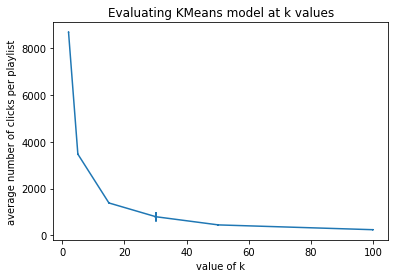

In [231]:
kvscore2 = np.array(kvscore)

errors = np.var(kvscore2[:,:,1]/10, axis = 1)
plt.errorbar(kvscore2[:, :, 0], kvscore2[:, :, 1]/10, yerr = errors)
plt.xlabel("value of k")
plt.ylabel("average number of clicks per playlist")
plt.title("Evaluating KMeans model at k values")
plt.show()


## 3.3 Evaluation for chosen K

In [82]:
### USE K=15 FOR KVALUE MODEL

start_time = time()

kvscore15 = []
kvscore_one_iter = []
labels15 = []

# 4 replicates again 
for i in range(4):
    
    # do kmeans with k = 15
    kmeans = KMeans(n_clusters=15).fit(meta_sample_tracks)
    labels15.append(kmeans.labels_)

    # test on 200 playlists this time so our data is more robust
    score_per_playlist = []
    for pid in list(set(meta_sample_playlists["pid"]))[:200]:
        this_playlist = meta_sample_playlists.loc[meta_sample_playlists["pid"] == pid]["tid"]
        train_playlist, test_playlist = train_test_split(this_playlist, test_size = 0.2, random_state = 42)

        if len(test_playlist) >= 10:

            # determine clusters that train songs belong to
            train_clusters = []
            for song in train_playlist:
                idx_song = np.where(song_ids == song)[0][0]
                song_assignment = kmeans.labels_[idx_song]
                train_clusters.append(song_assignment)

            # determine time to sample before hit in test set
            sample_cluster = train_clusters[np.random.randint(0, len(train_clusters))]
            songs_in_cluster = song_ids.loc[np.where(kmeans.labels_ == sample_cluster)[0]]
            song_sample_order = songs_by_popularity.loc[songs_by_popularity.index.isin(songs_in_cluster)]

            # check for hits
            n_sample = -1
            for i_t, track in enumerate(song_sample_order):
                if track in test_playlist:
                    n_sample = i_t
                    break;

            # continue checking for hits
            n_clusters_checked = 1
            while n_sample < 0:

                sample_cluster = train_clusters[np.random.randint(0, len(train_clusters))]
                songs_in_cluster = song_ids.iloc[np.where(kmeans.labels_ == sample_cluster)[0].tolist()]

                song_sample_order = songs_by_popularity.loc[songs_by_popularity.index.isin(songs_in_cluster)]
                n_clusters_checked += 1

                n_sample = -1
                for i_t, track in enumerate(song_sample_order):
                    if track in test_playlist:
                        n_sample = i_t
                        break;

                # if no matches found after checking all clusters
                if n_clusters_checked > len(train_clusters):
                    for sample_cluster in train_clusters:
                        songs_in_cluster = song_ids.iloc[np.where(kmeans.labels_ == sample_cluster)[0].tolist()]
                        n_sample += len(songs_in_cluster)
            score_per_playlist.append(n_sample / len(train_playlist))
    kvscore_one_iter.append([k, np.mean(score_per_playlist)])
kvscore15.append(kvscore_one_iter)

In [290]:
print("average clicks score for k = 15:", np.mean(np.array(kvscore15)[:, :, 1]/10))

average clicks score for k = 15: 1413.1388426880046


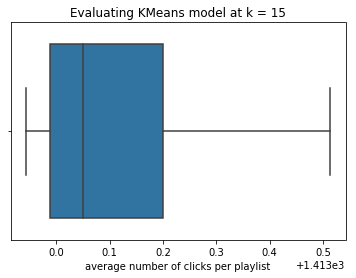

In [229]:
kvscore3 = np.array(kvscore15)

plt.xlabel("average number of clicks per playlist")
plt.title("Evaluating KMeans model at k = 15")
sns.boxplot(kvscore3[:, :, 1][0]/10)

## 3.4 PCA Visualization 

Despite the poor click performance, we also wanted to visualize the effects of our clustering algorithm itself. Thus, we conducted PCA to project the track data down to two dimensions. We plotted the first two principal components against one another and labeled the points with the labels calculated in one of the k-means replicates (where k = 15). 

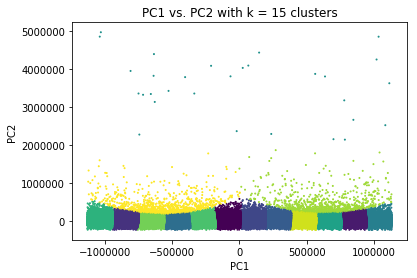

In [282]:
from sklearn.decomposition import PCA

pca = PCA(2)
pca.fit(meta_sample_tracks)

labels = labels15[np.argmin(kvscore3[:, :, 1][0])]

# Label to color dict (automatic)
label_color_dict = {label:idx for idx,label in enumerate(np.unique(labels))}

# Color vector creation
cvec = [label_color_dict[label] for label in labels]

plt_values = pca.transform(meta_sample_tracks)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs. PC2 with k = 15 clusters")
plt.scatter((plt_values[:, 0]), plt_values[:, 1], c = cvec, s = 1)

# Part 4: Final two stage model 

Given the relatively poor performance of both supervised and unsupervised models alone, we looked to literature for inspiration for a more powerful model. Ultimately, we chose to segment our model into two main stages. Given a set of songs (“Seed Songs”), the first stage of the model (“Top Song Selection”) aims to quickly return a large subset of songs (e.g. 20k) that are likely to be in the desired playlist seeded with the Seed Songs. This subset of songs is then fed into the second stage of the model (“Feature Extraction & Re-Ranking”), which then performs a more in-depth assessment of every song in this filtered subset before ranking them and returning the top-ranked N songs (“Recommendations”) as the final output of our model. 

In summary, the idea is that this process would reduce the bad click rate by heavily reducing the number of irrelvent songs before the final classifiation and ranking for recommendations. 

## 4.1 Stage 1

For the first stage of our model, we needed to develop a filtering mechanism that could reduce the search space of songs by about 100-fold. Because we were applying this algorithm to the full dataset of ~2M songs, this meant that our algorithm needed to 1) be computationally fast/effectively vectorized to speed up training and testing on the full dataset while 2) preserving as much accuracy as possible such that we did not filter out high-relevance songs.
One method that has become popular in the implicit recommendation literature is Weighted Regularized Matrix Factorization (WRMF), which has been shown to achieve state-of-the-art recommendation results in a computationally tractable manner. 

Given the complexity of the implementation, we produced the majority of the code for this stage in python scripts that are called by this notebook. 

Please see the following files for reference:
- https://github.com/maggiebasta/playlist-generation/blob/master/Models/wrmf.py
- https://github.com/maggiebasta/playlist-generation/blob/master/Models/wrmf_helpers.py

*Note:* There is also a much more in depth discussion of the theory and specifics of the implementation in the write up, but for clarity and brevity, we refrain from too much detail here. 

### Compute the wrmf factors 

In [2]:
"""
NOTE: ONLY RUN THIS IF YOU WANT TO RECOMPUTE WRMF WITH NEW PARAMS.
OTHERWISE USE PRECOMPUTED FACTORIZATION (STORED LOCALLY/IN DRIVE)
"""
# params = {
#     'factors': 20,
#     'reg': 0.1,
#     'iters': 20,
#     'alpha': 15
# }
# song_factors = get_wrmf_factors.get_fitted_wrmf(PATH_TO_SPARSE_MATRIX, params)

'\nNOTE: ONLY RUN THIS IF YOU WANT TO RECOMPUTE WRMF WITH NEW PARAMS.\nOTHERWISE USE PRECOMPUTED FACTORIZATION (STORED LOCALLY/IN DRIVE)\n'

### Get the song factorization 

In [3]:
with open('data/wrmf_factors.pickle', 'rb') as f:
    playlist_factors, song_factors = pickle.load(f)

print(song_factors.shape)
print(playlist_factors.shape)

(2029866, 20)
(800000, 20)


### Testing different factorizations

Given the computed factors, we were able to test different combinations for stage 1. Specifically, we could recommend a subset of songs based off song-to-song relationships (i.e. the similarity in playlist of between songs in terms of the playlists they are in), or playlist-to-song relationships (i.e. the similarity of songs to certain playlists and recommend songs in those playlists). Lastly, we could also recommend doing an ensembled combination of these two. 

### Example: get "n_similar" top songs for random seed songs 

An example of the functionality of this method is displayed below. In this example, we use the song-to-song relationship model. 

In [4]:
# example: It Wasn't Me, by Shaggy and Ignition - Remix
song_ids = ['1lzr43nnXAijIGYnCT8M8H', '5dNfHmqgr128gMY2tc5CeJ']
top_matches = wrmf_helpers.get_top_similar_from_tracks(song_factors, song_ids, n_similar_songs=10, verbose=True)


Recommended Songs for ["It Wasn't Me", 'Ignition - Remix']
------------------------------------------------------------
Track Name                                        Score
------------------------------------------------------------
Ignition - Remix                                  0.988374
It Wasn't Me                                      0.986951
Ride Wit Me                                       0.943358
Buy U a Drank (Shawty Snappin') (feat. Yung Joc)  0.928722
Playin' the Game                                  0.928006
Gold Digger                                       0.919052
Remix to Ignition                                 0.913630
Angel                                             0.910224
Yeah!                                             0.909689
Suga Suga                                         0.907704


### Example: get "n_similar" top songs for seed from actual test playlist

We can test out the various implementations of stage 1 by testing what percentage of the original playlist is included in the filtered songs. Specifically, for a set of test playlists, we extract 2 seed songs, feed them to stage 1 and see what perentage of the remaining playlist is included in the final output. 

Below, we include a specific example as well as overall testing performance on a larger test set. 

In [5]:
filename = '/Users/mabasta/Desktop/CS109a/playlist-generation/data/Songs/songs501.csv'
cols_ignore = ['pos', 'artist_name', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name']
df = pd.read_csv(filename).drop(columns = cols_ignore)

In [6]:
# print out the playlist
sample_playlists = [group.track_uri for _, group in df.groupby('pid')]
test_playlist = sample_playlists[0]
test_playlist = test_playlist.str.replace('spotify:track:', '')

for tid in test_playlist:
    print(wrmf_helpers.get_song_name(tid))

My Girl (feat. T. Gatez)
New Religion
Broad Shoulders (feat. Chance the Rapper)
Free
She Moves In Her Own Way
Don't Take the Money
that one song
Lovely
Always Like This
Twice
Caroline
Never Seen Anything "Quite Like You"
Sunshine & Kool-Aid
No Such Thing
Heart's Content
Smoke and Mirrors
Best For Last
90210 (feat. G-Eazy)
Spaces
Milk & Honey
Don't Dream It's Over
Lover Come Back
A Dream Is A Wish Your Heart Makes


In [7]:
# get similar using song to song
seed_ids = list(test_playlist[:2])
top_matches = wrmf_helpers.get_top_similar_from_tracks(
    song_factors,
    seed_ids,
    n_similar_songs=20000,
    verbose=False
)
overlaps = set(test_playlist).intersection(set(top_matches))
print(f"Found {len(overlaps)} overlaps:")
for overlap in overlaps:
    print(wrmf_helpers.get_song_name(overlap))

Found 9 overlaps:
that one song
A Dream Is A Wish Your Heart Makes
My Girl (feat. T. Gatez)
Sunshine & Kool-Aid
Free
Caroline
Milk & Honey
Lovely
New Religion


In [8]:
# get similar using playlist to song
top_matches = wrmf_helpers.get_top_similar_from_playlists(
    song_factors,
    playlist_factors,
    seed_ids,
    n_similar_songs=20000,
    n_similar_playlists=200
)
overlaps = set(test_playlist).intersection(set(top_matches))
print(f"Found {len(overlaps)} overlaps:")
for overlap in overlaps:
    print(wrmf_helpers.get_song_name(overlap))

Found 14 overlaps:
She Moves In Her Own Way
Always Like This
that one song
My Girl (feat. T. Gatez)
90210 (feat. G-Eazy)
Sunshine & Kool-Aid
Lover Come Back
Broad Shoulders (feat. Chance the Rapper)
Caroline
Twice
Milk & Honey
Smoke and Mirrors
New Religion
No Such Thing


In [9]:
# get similar using ensemble playlist and song

top_matches = wrmf_helpers.get_top_similar_from_ensemble(
    song_factors,
    playlist_factors,
    seed_ids,
    n_similar_songs=20000,
    n_similar_playlists=200
)
overlaps = set(test_playlist).intersection(set(top_matches))
print(f"Found {len(overlaps)} overlaps:")
for overlap in overlaps:
    print(wrmf_helpers.get_song_name(overlap))

Found 16 overlaps:
She Moves In Her Own Way
Always Like This
that one song
My Girl (feat. T. Gatez)
90210 (feat. G-Eazy)
Sunshine & Kool-Aid
Lover Come Back
Broad Shoulders (feat. Chance the Rapper)
Caroline
Twice
Milk & Honey
Heart's Content
Never Seen Anything "Quite Like You"
Smoke and Mirrors
New Religion
No Such Thing


### Visualizations

In [10]:
output_sizes = [500, 1000, 5000, 10000, 15000, 20000, 30000]

In [11]:
"""
WARNING: NOT RECOMMENDED TO RUN THIS CODE. IT WILL TAKE FOREVER. USE THE STORED PICKLE FILES 
TO GET PREVIOUSLY COMPUTED RESULTS.
"""

# song_to_song = {size: [] for size in output_sizes}
# playlist_to_song = {size: [] for size in output_sizes}
# ensemble = {size: [] for size in output_sizes}

# for i, test_playlist in enumerate(test_playlists[:30]):
#     test_playlist = test_playlist.str.replace('spotify:track:', '')
#     n = len(test_playlist)
#     test_playlist_set = set(test_playlist)
#     seed_ids = []
#     while len(seed_ids) < 2:
#         rand =list(test_playlist.sample(n=1))[0]
#         if rand in tid_to_idx:
#             seed_ids.append(rand)
#     for output_size in output_sizes:
#         print(i, output_size)
#         song_to_song_matches = wrmf_helpers.get_top_similar_from_tracks(
#             song_factors,
#             seed_ids,
#             n_similar_songs=output_size,
#             verbose=False
#         )
#         song_to_song[output_size].append(len(test_playlist_set.intersection(set(song_to_song_matches)))/n)

#         playlist_to_song_matches = wrmf_helpers.get_top_similar_from_playlists(
#             song_factors,
#             playlist_factors,
#             seed_ids,
#             n_similar_songs=output_size,
#             n_similar_playlists=200
#         )
#         playlist_to_song[output_size].append(len(test_playlist_set.intersection(set(playlist_to_song_matches)))/n)

#         ensemble_matches = wrmf_helpers.get_top_similar_from_ensemble(
#             song_factors,
#             playlist_factors,
#             seed_ids,
#             n_similar_songs=output_size,
#             n_similar_playlists=200
#         )
#         ensemble[output_size].append(len(test_playlist_set.intersection(set(ensemble_matches)))/n)

# with open('data/wrmf_models_results.pickle', 'wb') as fd:
#     pickle.dump((song_to_song, playlist_to_song, ensemble), fd)

'\nWARNING: NOT RECOMMENDED TO RUN THIS CODE. IT WILL TAKE FOREVER. USE THE STORED PICKLE FILES \nTO GET PREVIOUSLY COMPUTED RESULTS.\n'

In [12]:
with open('data/wrmf_models_results.pickle', 'rb') as f:
    song_to_song, playlist_to_song, ensemble = pickle.load(f)

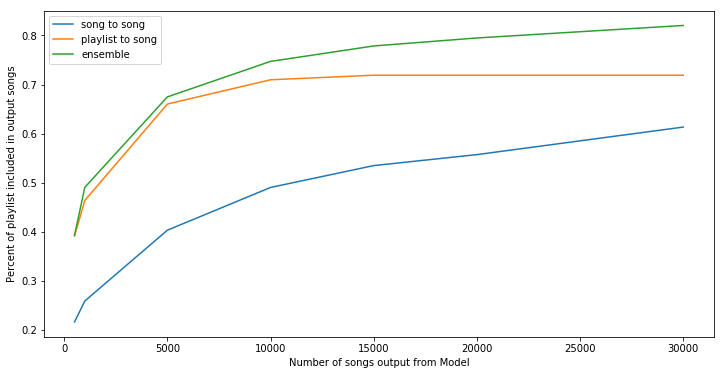

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
x = output_sizes
ax.plot(x, [np.array(v).mean() for v in song_to_song.values()], label='song to song')
ax.plot(x, [np.array(v).mean() for v in playlist_to_song.values()], label='playlist to song')
ax.plot(x, [np.array(v).mean() for v in ensemble.values()], label='ensemble')
ax.legend()

ax.set_xlabel("Number of songs output from Model")
ax.set_ylabel("Percent of playlist included in output songs")

plt.show()

##  4.2 Stage 2

After filtering down the number of total songs considered for a given input playlist through the WRMF-based ensemble model, the next step was to pass this list of candidate songs to another model that would then apply a more rigorous scoring mechanism to evaluate and rank all of the candidate songs. This ranking would then be used as the overall output of our model.

In order to facilitate this transition, we implemented a pipeline in Python to efficiently process and pass the list of candidate songs to the second-stage model. We heavily leaned on the Pickle library to save our models at regular intervals (to both allow for cross validation testing as well as avoid the loss of a trained model due to unanticipated kernel crashes), and used this data format to share pre-processed data and trained models between Python scripts. We also took care to ensure that we standardized the formatting of our datasets, which we achieved by using a unified set of Python classes to store Track and Playlist objects, as well as a set of files that mapped individual tracks to their corresponding Track Objects (with associated audio features imported from the Spotify API) as well as their indices in the sparse matrices used for the WRMF computations.

Similarly to the supervised models from our exploratory modeling, we looked into logistic regression and tree based models for this stage. Additionally, we created an XGBoost implementation.

###  Extract and store features

In [14]:
"""
WARNING: NOT RECOMMENDED TO RUN THIS CODE. IT WILL TAKE FOREVER. USE THE STORED PICKLE FILES 
TO GET PREVIOUSLY COMPUTED RESULTS.
"""

# these lines are uncommented for later visuals
train_playlists = []
for i in range(1, 10):
    filename = f'/Users/mabasta/Desktop/CS109a/playlist-generation/data/Songs/songs{i}.csv'
    cols_ignore = ['pos', 'artist_name', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name']
    df = pd.read_csv(filename).drop(columns = cols_ignore)
    train_playlists.extend([group.track_uri for _, group in df.groupby('pid')])

# val_playlists = []
# for i in range(10, 12):
#     filename = f'/Users/mabasta/Desktop/CS109a/playlist-generation/data/Songs/songs{i}.csv'
#     cols_ignore = ['pos', 'artist_name', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name']
#     df = pd.read_csv(filename).drop(columns = cols_ignore)
#     val_playlists.extend([group.track_uri for _, group in df.groupby('pid')])

# _, tid_to_idx, _, _, _ = wrmf_helpers.get_user_item_sparse_matrix(PATH_TO_SPARSE_MATRIX)

# """
# Generate train dataset from stage 1 data
# """
# train_dfs = []
# start_time = time.time()
# start = 0
# end = 3000
# for i in range(start, end):
#     try:
#         if len(train_playlists[i]) > 2:
#             train_dfs.append(compute_df(train_playlists[i], song_factors, playlist_factors))
# #             train_dfs.append(compute_df_v2(train_playlists[i])
#     except (KeyError, AttributeError) as e:
#         print(f'Error on playlist{i}. Skipping')

#     current_time = time.time()
#     elapsed_time = current_time - start_time
#     time_left = (end-start) * elapsed_time / float(i+1-start) - elapsed_time
#     sys.stdout.write(
#         f"\rParsed playlist {i+1}. Time elapsed: {str(datetime.timedelta(seconds=elapsed_time))[:-7]}. Time remaining: {str(datetime.timedelta(seconds=time_left))[:-7]}")
#     sys.stdout.flush()

# train_df = pd.concat(train_dfs)

# with open('../data/stage_2_train.pickle', 'wb') as f:
#     pickle.dump(train_df , f)
    

# val_dfs = []
# start_time = time.time()
# start = 0
# end = 100
# for i in range(start, end):
#     try:
#         if len(val_playlists[i]) > 2:
#     #         val_dfs.append(compute_df_v2(val_playlists[i]))
#             val_dfs.append(compute_df(val_playlists[i], song_factors, playlist_factors))
#     except (KeyError, AttributeError) as e:
#         print(f'Error on playlist{i}. Skipping')
#     current_time = time.time()
#     elapsed_time = current_time - start_time
#     time_left = (end-start) * elapsed_time / float(i+1-start) - elapsed_time
#     sys.stdout.write(
#         f"\rParsed playlist {i+1}. Time elapsed: {str(datetime.timedelta(seconds=elapsed_time))[:-7]}. Time remaining: {str(datetime.timedelta(seconds=time_left))[:-7]}")
#     sys.stdout.flush()

# val_df = pd.concat(val_dfs)

# """
# Generate validation dataset from stage 1 data
# """
# with open('../data/stage_2_val.pickle', 'wb') as f:
#     pickle.dump(val_df , f)

### Train stage 2 models

In [15]:
with open('data/stage_2_train.pickle', 'rb') as f:
    train_df = pickle.load(f)
with open('data/stage_2_val.pickle', 'rb') as f:
    val_df = pickle.load(f)

In [83]:
ytrain = train_df['relevence']
Xtrain = train_df.drop('relevence', axis=1)

yval = val_df['relevence']
Xval = val_df.drop('relevence', axis=1)

### Logistic Regression

In [17]:
log_model = LogisticRegressionCV(cv=3).fit(Xtrain, ytrain)

pred_train = log_model.predict(Xtrain)
print("Logistic regression training accuracy: %.2f" % (accuracy_score(ytrain, pred_train) * 100))

pred_val = log_model.predict(Xval)
print("Logistic regression test accuracy: %.2f" % (accuracy_score(yval, pred_val) * 100))

Logistic regression training accuracy: 50.00
Logistic regression test accuracy: 50.00


### Decision Tree w/ CV¶

In [18]:
depths = np.arange(1, 16, 2)
dt_model = GridSearchCV(
    DecisionTreeClassifier(),
    dict(max_depth = depths),
    cv=5,
    return_train_score=True
).fit(Xtrain, ytrain)

pred_train = dt_model.predict(Xtrain)
print("DT training accuracy: %.2f" % (accuracy_score(ytrain, pred_train) * 100))

pred_val = dt_model.predict(Xval)
print("DT test accuracy: %.2f" % (accuracy_score(yval, pred_val) * 100))

DT training accuracy: 63.90
DT test accuracy: 61.99


### XG Boost

In [19]:
xgb_model = xgb.XGBClassifier(n_estimators=150, max_depth=10, learning_rate=0.1, subsample=0.5).fit(Xtrain, ytrain)

pred_train = xgb_model.predict(Xtrain)
print("XG Boost training accuracy: %.2f" % (accuracy_score(ytrain, pred_train) * 100))

pred_val = xgb_model.predict(Xval)
print("XG Boost test accuracy: %.2f" % (accuracy_score(yval, pred_val) * 100))

XG Boost training accuracy: 90.52
XG Boost test accuracy: 69.29


## 4.3 Test for clicks on witheld playlists

In [20]:
test_playlists = []
for i in range(800, 810):
    filename = f'/Users/mabasta/Desktop/CS109a/playlist-generation/data/Songs/songs{i}.csv'
    cols_ignore = ['pos', 'artist_name', 'artist_uri', 'track_name', 'album_uri', 'duration_ms', 'album_name']
    df = pd.read_csv(filename).drop(columns = cols_ignore)
    test_playlists.extend([group.track_uri for _, group in df.groupby('pid')])

In [21]:
# Logistic Regression 
start = 1
end = 40

log_train_clicks = []
log_test_clicks = []
for i in range(start, end):
    try:
        if len(train_playlists[i]) > 50:
            train_click_score = get_model_clickscore(train_playlists[i], log_model)
            log_train_clicks.append(train_click_score)
        if len(test_playlists[i]) > 50:
            test_click_score = get_model_clickscore(test_playlists[i], log_model)
            log_test_clicks.append(test_click_score)
    except (KeyError, AttributeError):
        pass

In [22]:
# Decision Tree w/ CV test
start = 1
end = 40

dr_train_clicks = []
dt_test_clicks = []
for i in range(start, end):
    try:
        if len(train_playlists[i]) > 50:
            train_click_score = get_model_clickscore(train_playlists[i], dt_model)
            dr_train_clicks.append(train_click_score)
        if len(test_playlists[i]) > 50:
            test_click_score = get_model_clickscore(test_playlists[i], dt_model)
            dt_test_clicks.append(test_click_score)
    except (KeyError, AttributeError):
        pass

In [23]:
# XG boost test
start = 1
end = 40

xgb_train_clicks = []
xgb_test_clicks = []
for i in range(start, end):
    try:
        if len(train_playlists[i]) > 50:
            train_click_score = get_model_clickscore(train_playlists[i], xgb_model)
            xgb_train_clicks.append(train_click_score)
        if len(test_playlists[i]) > 50:
            test_click_score = get_model_clickscore(test_playlists[i], xgb_model)
            xgb_test_clicks.append(test_click_score)
    except (KeyError, AttributeError):
        pass

In [24]:
df_dict = {
    'logistic regression': [pd.Series(log_train_clicks).median(), pd.Series(log_test_clicks).median()],
    'decision tree': [pd.Series(dr_train_clicks).median(), pd.Series(dt_test_clicks).median()],
    'xgboost': [pd.Series(xgb_train_clicks).median(), pd.Series(xgb_test_clicks).median()]
}
df = pd.DataFrame.from_dict(df_dict, orient='index', columns=['train clicks', 'test clicks'])
df

,train clicks,test clicks
logistic regression,14.5,26.5
decision tree,30.0,41.5
xgboost,18.0,21.0


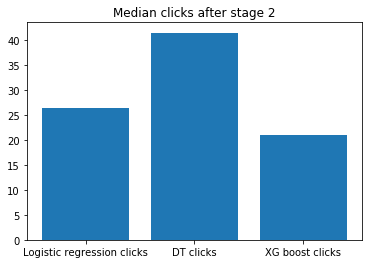

In [25]:
x = ['Logistic regression clicks', 'DT clicks', 'XG boost clicks']
y = [pd.Series(log_test_clicks).median(), pd.Series(dt_test_clicks).median(), pd.Series(xgb_test_clicks).median()]
plt.bar(x, y)
plt.title("Median clicks after stage 2")
plt.show()

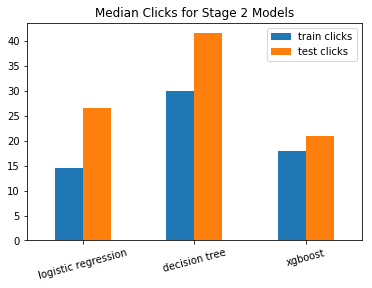

In [26]:
df.plot.bar(rot=15, title="Median Clicks for Stage 2 Models");

plt.show(block=True);